In [2]:
import pandas as pd
import json
import dateparser
%pylab inline
#print dateparser.parse(" 1200").date()

#load about_pages
about_pages=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)#885
df=about_pages
#Remove data where there is no male person neither female  simultaneously
df_0=df[(df.male_person_amount==0)& (df.female_person_amount==0)]#628
df=df[(df.male_person_amount>0)| (df.female_person_amount>0)]#257
print "There are ",len(df),"profesions with at least one person"

There are  257 profesions with at least one person


In [12]:
from wikitools import wiki, api
from datetime import datetime, timedelta, date

def get_text(titles):
    site = wiki.Wiki("https://de.wikipedia.org/w/api.php") 
    params={'action':'query','titles':titles,'formatversion':'2',
                    'prop':'extracts','exintro':'','explaintext':'',
                    'redirects':'','continue':''}
    request = api.APIRequest(site, params) 
    result=request.query()
    if result["query"]["pages"][0].get("title"):
        n=result["query"]["pages"][0]["extract"]
        if "(*" in n:
            try:
                #print dateparser.parse(n.split("(* ")[1].split(" in ")[0]).date()
                return dateparser.parse(n.split("(* ")[1].split(" in ")[0]).date()
            except:
                #print n
                pass
        else:
            #print n
            pass

def wikitool_retrieve(lang,titles): 
    w=""
    wikiid=0
    site = wiki.Wiki("https://"+lang+".wikipedia.org/w/api.php") 
    params={'action':'query','titles':titles,'prop':'langlinks', 
                 'lllang':'en','lllimit':'500','format':'json','redirects':'','continue':''} 
    request = api.APIRequest(site, params)   
    result=request.query() 
    if result["query"]["pages"].values()[0].get("title"): 
        n=result["query"]["pages"].values()[0] 
        if n.get("langlinks"): 
            w=n["langlinks"][0]["*"]
            site = wiki.Wiki("https://en.wikipedia.org/w/api.php") 
            params={'action':'query','titles':w,'format':'json','redirects':'','continue':''} 
            request = api.APIRequest(site, params) 
            result=request.query() 
            if result["query"]["pages"].values()[0].get("title"): 
                wikiid=result["query"]["pages"].values()[0]["pageid"]  
        else:
            return "99" , wikiid
            

            
    return w , wikiid


from SPARQLWrapper import SPARQLWrapper, JSON

def get_country_description(query):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setReturnFormat(JSON)

    sparql.setQuery(query)  # the previous query as a literal string
    res=sparql.query().convert()
    return res["results"][u'bindings']



def wiki_dbpedia_age(titles):
    date_names=[]
    for title in titles:
        name,a=wikitool_retrieve("de",title) 
        if name=="99":
            print title, a
            date_names.append(get_text(title))
        elif a>0:
            query="""PREFIX dbo:<http://dbpedia.org/ontology/> 
            PREFIX dbp: <http://dbpedia.org/property/>
            SELECT ?age ?age2 WHERE { ?person dbo:wikiPageID """+str(a)+""" .
            {?person dbp:birthDate ?age .}
            UNION
             { ?person dbo:birthDate ?age2 . } }"""
            age=get_country_description(query)
            if len(age)>0:
                
                if len(age)>1:
                    if (age[1].has_key("age")): 
                        #print age[0]["age"]["type"],age[0]["age"]["value"]
                        date_names.append(age[0]["age"]["value"])
                    elif age[1]["age2"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#date':
                        #print datetime.strptime(age[1]["age2"]["value"], '%Y-%m-%d').date()
                        if age[1]["age2"]["value"][0]!="-":
                            date_names.append(datetime.strptime(age[1]["age2"]["value"], '%Y-%m-%d').date())
                        else:
                            date_names.append(int(age[1]["age2"]["value"][:4]))
                    elif age[1]["age2"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#gYear':
                        #print int(age[1]["age2"]["value"])
                        date_names.append(int(age[1]["age2"]["value"]))
                    else:
                        #print age[1]["age2"]["type"],age[1]["age2"]["value"] 
                        date_names.append(age[1]["age2"]["value"])
                elif age[0].has_key("age"):
                    if age[0]["age"].has_key("datatype"):
                        if age[0]["age"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#date':
                            #print datetime.strptime(age[0]["age"]["value"], '%Y-%m-%d').date()
                            date_names.append(datetime.strptime(age[0]["age"]["value"], '%Y-%m-%d').date())
                    else:
                        #print age[0]["age"]["type"],age[0]["age"]["value"]
                        date_names.append(age[0]["age"]["value"])
                else:
                    
                    if age[0]["age2"]["datatype"]==u'http://www.w3.org/2001/XMLSchema#date':
                        #print datetime.strptime(age[0]["age2"]["value"], '%Y-%m-%d').date()
                        date_names.append(datetime.strptime(age[0]["age2"]["value"], '%Y-%m-%d').date())
                    else:
                        #print age[0]["age2"]["type"],age[0]["age2"]["value"]
                        date_names.append(age[0]["age2"]["value"])
            else:
                #print title, a
                date_names.append(get_text(title))
                #print "============>>>>>>>"
        else:
            #print "No page found"
            pass
    return date_names
#titles=["Archimedes","Sokrates","Fritz_Croner","Fritz_Schulz_(Schauspieler)",u'Heinrich_B\xf6ll']
#titles=["Fritz_Croner"]
#titles=[u'Wilhelm_Busch', u'Salomo', u'Imhotep', u'Sokrates', u'Platon', u'Zarathustra', u'Konfuzius', u'Laotse',
# u'Thomas_von_Aquin', u'Augustinus_von_Hippo', u'Ambrosius_von_Mailand', u'Basilius_von_Caesarea',
# u'Athanasius_der_Gro\xdfe', u'Albertus_Magnus', u'Benedikt_XVI.', u'Jean_Baptiste_de_La_Salle']
#wiki_dbpedia_age(titles)

In [10]:
from collections import defaultdict
dict_prof_names=defaultdict(dict)

for p,names in df.male_person.iteritems():
    list_names=names.replace("[","").replace("]","").split(", ")
    if list_names[0]!=u'':
        print list_names
        d=wiki_dbpedia_age(list_names)
        #print d
        dict_prof_names[p]["men"]=d
    else:
        pass

[u'Karl_Martell', u'Leo_X.', u'Franz_I._(Frankreich)', u'Leo_XIII.']
[u'Fritz_Croner', u'Michel_Crozier', u'Arnd_Zschiesche', u'Charles_Wright_Mills', u'J\xfcrgen_Kocka', u'Siegfried_Kracauer', u'Herman_Melville']
Fritz_Croner 0
1896-02-27
Arnd_Zschiesche 0
1972-05-27
[u'L\xe9o_Apotheker', u'Friedrich_II._(HRR)', u'Friedrich_Wilhelm_Adam_Sert\xfcrner', u'August_Oetker', u'Ernst_Christian_Friedrich_Schering', u'Emanuel_Merck', u'Carl_Leverkus', u'John_Pemberton', u'Felix_Hoffmann', u'Max_von_Pettenkofer', u'Hugo_Erfurt', u'Ernst_Gustav_Leube', u'James_Parkinson', u'John_Langdon-Down', u'Nostradamus', u'Georg_Trakl', u'Ludwig_Bechstein', u'Theodor_Fontane', u'Carl_Spitzweg', u'Johann_Bartholom\xe4us_Trommsdorff']
Ernst_Gustav_Leube 0
1808-05-23
[u'Eug\xe8ne_Viollet-le-Duc', u'Vitruv']
Vitruv 32794
Vitruv (Marcus Vitruvius Pollio) war ein römischer Architekt, Ingenieur und Architekturtheoretiker. Er lebte im 1. Jahrhundert v. Chr.
============>>>>>>>
[u'Michael_Diefenbacher']
Michael_Dief

C:\Anaconda\lib\site-packages\wikitools\api.py:155: FutureWarning: The querycontinue option is deprecated and will be removed
in a future release, use the new queryGen function instead
for queries requring multiple requests
  for queries requring multiple requests""", FutureWarning)


In [11]:
for p,names in df.female_person.iteritems():
    list_names=names.replace("[","").replace("]","").split(", ")
    if list_names[0]!=u'':
        print list_names
        d=wiki_dbpedia_age(list_names)
        #print d
        dict_prof_names[p]["women"]=d
    else:
        pass

[u'Irmgard_Keun']
[u'Magdalena_Meub']
Magdalena_Meub 0
1881-02-09
[u'Henriette_Heber', u'Christine_R\xe4dlinger']
Henriette_Heber 0
1795-05-15
Christine_Rädlinger 0
Christine Rädlinger (* 1954) ist eine deutsche Historikerin und Schriftstellerin. Sie schreibt vor allem über die Münchner Stadtgeschichte.


[u'Gertrude_Cepl-Kaufmann']
Gertrude_Cepl-Kaufmann 0
1942-02-27
[u'Carla_Bley', u'Melba_Liston', u'Maria_Schneider_(Komponistin)', u'Mary_Lou_Williams']
[u'Lily_Braun', u'Caroline_Loyo', u'Therese_Renz', u'Jenny_von_Rahden', u'Katharina_Brumbach', u'Claire_Heliot', u'Tilly_B\xe9b\xe9']
Caroline_Loyo 0
Caroline Loyo (* um 1816; † 1892 in Paris oder 1895 in Bléré) war eine französische Schulreiterin. Sie gilt als die erste Reiterin der Hohen Schule im Zirkus.


Therese_Renz 0
1859-04-10
Jenny_von_Rahden 0
Jenny von Rahden (* im 19. Jahrhundert in Breslau; † 1921 in Paris) war eine deutsche Kunstreiterin, Schriftstellerin und Sängerin.


typed-literal 1884
Claire_Heliot 0
1866-02-09
Till

In [14]:
import re
dict_prof_names2_m=defaultdict(list)
dict_prof_names2=defaultdict(dict)
dict_prof_names2_f=defaultdict(list)
from datetime import datetime, timedelta, date
for p in dict_prof_names:
    if dict_prof_names[p].has_key("men"):
        for d in dict_prof_names[p]["men"]:   
            d2=None
            if isinstance(d, date): 
                d2=d
            elif d is not None:
                try:
                    d2=datetime.strptime(str(d), '%Y').date()
                except:
                    if isinstance( d, int ):
                        if d<=0:
                            d2=datetime.strptime("0001", '%Y').date()
                        else:
                            if len(str(d))==3:
                                d2=datetime.strptime("0"+str(d), '%Y').date()
                            else:
                                d2=datetime.strptime("00"+str(d) if len(str(d))==2 else "000"+str(d), '%Y').date()
                    elif dateparser.parse(str(d)):
                        if d[0]!="-":
                            d2=dateparser.parse(str(d)).date()
                        else:
                            print d
                    elif "BC" in d:
                        d2=datetime.strptime("0001", '%Y').date()
                    else:
                        if len(re.findall("[-\d]+", d)):
                            numb=int(re.findall("[-\d]+", d)[0])
                            if numb<=0:
                                d2=datetime.strptime("0001", '%Y').date()
                            else:
                                if len(str(numb))==3:
                                    d2=datetime.strptime("0"+str(numb), '%Y').date()
                                elif len(str(numb))==4:
                                    d2=datetime.strptime(str(numb), '%Y').date()
                                else:
                                    d2=datetime.strptime("00"+str(numb) if len(str(numb))==2 else"000"+str(numb),'%Y').date()
                        else:
                            print d,"==="
            if d2:
                dict_prof_names2_m[p].append(d2)
                if dict_prof_names2[p].has_key("men"):
                    dict_prof_names2[p]["men"].append(d2)
                else:
                    dict_prof_names2[p]["men"]=[d2]
                
    if dict_prof_names[p].has_key("women"):
        for d in dict_prof_names[p]["women"]: 
            d2=None
            if isinstance(d, date): 
                d2=d
            elif d is not None:
                try:
                    d2=datetime.strptime(str(d), '%Y').date()
                except:
                    if isinstance( d, int ):
                        d2=datetime.strptime("0"+str(d), '%Y').date()
                    else:
                        print d

            if d2:
                dict_prof_names2_f[p].append(d2)
                if dict_prof_names2[p].has_key("women"):
                    dict_prof_names2[p]["women"].append(d2)
                else:
                    dict_prof_names2[p]["women"]=[d2]         

-1302
--02-27
Unknown ===
Date unknown
unknown ===
mid third century
Unknown ===


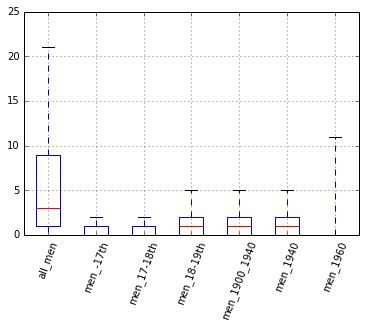

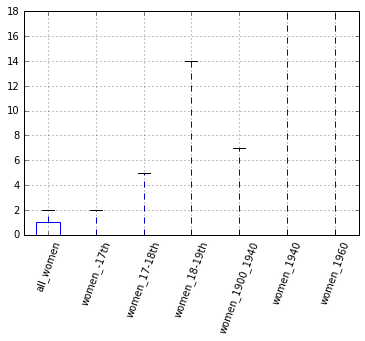

In [17]:
from collections import Counter
import pandas as pd
df_dat=pd.DataFrame.from_dict(dict_prof_names2,orient='index')
df_dat.fillna(value=0, inplace=True)

def group_by_century(x,y):
    new_d_1700=[]
    new_d_1700_1800=[]
    new_d_1800_1900=[]
    new_d_1900_1940=[]
    new_d_1940=[]
    new_d_1960=[]
    if isinstance(x, list):
        for d in x:
            if d>datetime.strptime("1940-1-1", '%Y-%m-%d').date():
                new_d_1940.append(d)
                if d>datetime.strptime("1960-1-1", '%Y-%m-%d').date():
                    new_d_1960.append(d)
            elif d>datetime.strptime("1900-1-1", '%Y-%m-%d').date():
                new_d_1900_1940.append(d)
            elif d>datetime.strptime("1800-1-1", '%Y-%m-%d').date():
                new_d_1800_1900.append(d)
            elif d>datetime.strptime("1700-1-1", '%Y-%m-%d').date():
                new_d_1700_1800.append(d)
            else:
                new_d_1700.append(d)    
        return pd.Series({'all_'+y: len(x), y+'_1940': len(new_d_1940), y+'_1960': len(new_d_1960),
                         y+'_1900_1940': len(new_d_1900_1940),y+'_18-19th': len(new_d_1800_1900),
                         y+'_17-18th': len(new_d_1700_1800),y+'_-17th': len(new_d_1700)})
    else:
        return pd.Series({'all_'+y: 0, y+'_1940': 0, y+'_1960': 0,y+'_1900_1940': 0})
dff=df_dat.men.apply(lambda x: group_by_century(x,"men"))
dff.boxplot(return_type='axes',showfliers=False)
plt.xticks(rotation=70)
plt.show()
dff_w=df_dat.women.apply(lambda x: group_by_century(x,"women"))
dff_w.boxplot(return_type='axes',showfliers=False)
plt.xticks(rotation=70)
plt.ylim(0,18)
plt.show()

In [18]:
df_m_w=pd.concat([dff,dff_w], axis=1)
df_m_w.fillna(value=0, inplace=True)

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text xticklabel objects>)

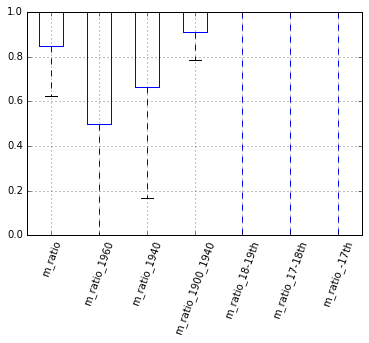

In [19]:
df_m_w["m_ratio"]=df_m_w.apply(lambda x: float(x["all_men"])/float(x["all_men"] + x["all_women"]), axis = 1)
df_m_w["m_ratio_1960"]=df_m_w.apply(lambda x: float(x.men_1960)/float(x.men_1960+x.women_1960) \
                                    if float(x.men_1960+x.women_1960)>0 else None, axis = 1)
df_m_w["m_ratio_1940"]=df_m_w.apply(lambda x: float(x.men_1940)/float(x.men_1940+x.women_1940) \
                                    if float(x.men_1940+x.women_1940)>0 else None, axis = 1)
df_m_w["m_ratio_1900_1940"]=df_m_w.apply(lambda x: float(x.men_1900_1940)/float(x.men_1900_1940+x.women_1900_1940) \
                                         if float(x.men_1900_1940+x.women_1900_1940)>0 else None, axis = 1)
df_m_w["m_ratio_18-19th"]=df_m_w.apply(lambda x: float(x["men_18-19th"])/float(x["men_18-19th"]+x["women_18-19th"]) \
                                         if float(x["men_18-19th"]+x["women_18-19th"])>0 else None, axis = 1)
df_m_w["m_ratio_17-18th"]=df_m_w.apply(lambda x: float(x["men_17-18th"])/float(x["men_17-18th"]+x["women_17-18th"]) \
                                         if float(x["men_17-18th"]+x["women_17-18th"])>0 else None, axis = 1)
df_m_w["m_ratio_-17th"]=df_m_w.apply(lambda x: float(x["men_-17th"])/float(x["men_-17th"]+x["women_-17th"]) \
                                         if float(x["men_-17th"]+x["women_-17th"])>0 else None, axis = 1)
g=df_m_w.boxplot(column=["m_ratio","m_ratio_1960","m_ratio_1940","m_ratio_1900_1940","m_ratio_18-19th",
                         "m_ratio_17-18th","m_ratio_-17th"],
                 return_type="axes",showfliers=False)
plt.xticks(rotation=70)

In [ ]:
df_m_w=pd.DataFrame.from_csv("de/people_with_birthDate.csv",encode="utf8")

In [20]:
std_2=df_m_w.m_ratio.std()*2
mean_m=df_m_w.m_ratio.mean()
std_2_=df_m_w.m_ratio_1960.std()*2
mean_m_=df_m_w.m_ratio_1960.mean()
df1=df_m_w[ abs(df_m_w.m_ratio - mean_m)<std_2]["m_ratio"]
df2=df_m_w[ abs(df_m_w.m_ratio_1960 - mean_m_)<std_2_]["m_ratio_1960"]
df_m_w2=pd.concat([df1,df2],axis=1)

std_2=df_m_w.m_ratio_1940.std()*2
mean_m=df_m_w.m_ratio_1940.mean()
df2=df_m_w[ abs(df_m_w.m_ratio_1940 - mean_m)<std_2]["m_ratio_1940"]
df_m_w2=pd.concat([df_m_w2,df2],axis=1)

std_2=df_m_w.m_ratio_1900_1940.std()*2
mean_m=df_m_w.m_ratio_1900_1940.mean()
df2=df_m_w[ abs(df_m_w.m_ratio_1900_1940 - mean_m)<std_2]["m_ratio_1900_1940"]
df_m_w2=pd.concat([df_m_w2,df2],axis=1)

std_2=df_m_w["m_ratio_18-19th"].std()*2
mean_m=df_m_w["m_ratio_18-19th"].mean()
df2=df_m_w[ abs(df_m_w["m_ratio_18-19th"] - mean_m)<std_2]["m_ratio_18-19th"]
df_m_w2=pd.concat([df_m_w2,df2],axis=1)

std_2=df_m_w["m_ratio_17-18th"].std()*2
mean_m=df_m_w["m_ratio_17-18th"].mean()
df2=df_m_w[ abs(df_m_w["m_ratio_17-18th"] - mean_m)<std_2]["m_ratio_17-18th"]
df_m_w2=pd.concat([df_m_w2,df2],axis=1)

(0, 1.02)

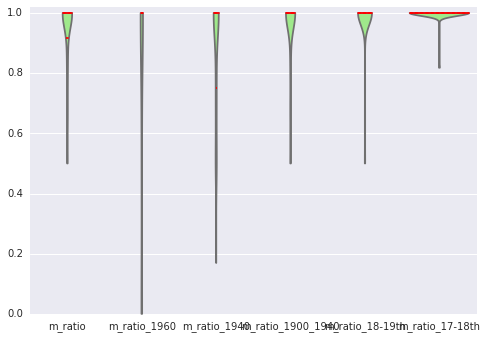

In [109]:
import seaborn as sns
g=sns.violinplot(data=df_m_w2,cut=0,trim=True,inner="quartile",
                 palette=[sns.xkcd_rgb["light green"]])
plt.ylim(0,1.02)

In [110]:
print df_m_w.men_1960.sum(),df_m_w.women_1960.sum(),df_m_w.all_men.sum()-df_m_w.men_1960.sum(),\
df_m_w.all_women.sum()-df_m_w.women_1960.sum()

144.0 83.0 2124.0 234.0


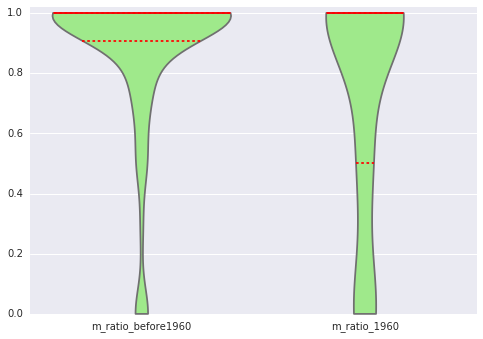

In [23]:
import seaborn as sns 
df_m_w["m_ratio_before1960"]=df_m_w.apply(lambda x: (float(x.all_men)-float(x.men_1960))/\
                                          float(x.all_men-x.men_1960+x.all_women-x.women_1960) \
                                    if float(x.all_men-x.men_1960+x.all_women-x.women_1960)>0 else None, axis = 1)
g=sns.violinplot(data=df_m_w[["m_ratio_before1960","m_ratio_1960"]],cut=0,trim=True,inner="quartile",
                 palette=[sns.xkcd_rgb["light green"]])
plt.ylim(0,1.02)
plt.show()

std_2=df_m_w["m_ratio_before1960"].std()*2
mean_m=df_m_w["m_ratio_before1960"].mean()
df2=df_m_w[ abs(df_m_w["m_ratio_before1960"] - mean_m)<std_2]["m_ratio_before1960"]
df_m_w2=pd.concat([df_m_w2,df2],axis=1)



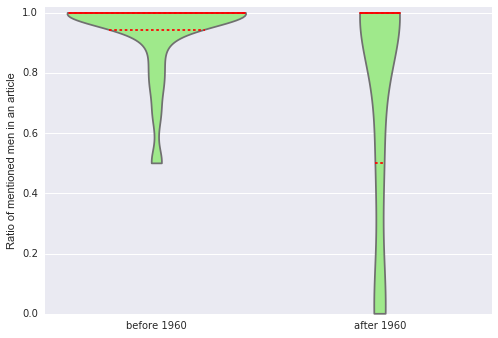

In [24]:

g=sns.violinplot(data=df_m_w2[["m_ratio_before1960","m_ratio_1960"]],cut=0,trim=True,inner="quartile",
                 palette=[sns.xkcd_rgb["light green"]])
plt.ylim(0,1.02)
plt.ylabel("Ratio of mentioned men in an article")
#plt.xlabel("")
plt.xticks([0,1],["before 1960","after 1960"])
plt.savefig("de/plots/violin_1960.png",dpi=500, bbox_inches='tight')
plt.show()

In [38]:
a=[]
for i in df_m_w.index.values:
    a.append( i.encode("utf8"))#.decode('iso-8859-1').
df_m_w.index=a
df_m_w.to_csv("de/people_with_birthDate.csv",encode="utf8")

,all_men,men_-17th,men_17-18th,men_18-19th,men_1900_1940,men_1940,men_1960,all_women,women_-17th,women_17-18th,...,women_1940,women_1960,m_ratio,m_ratio_1960,m_ratio_1940,m_ratio_1900_1940,m_ratio_18-19th,m_ratio_17-18th,m_ratio_-17th,m_ratio_before1960
Abt,4,3,0,1,0,0,0,0,0,0,...,0,0,1.000000,NaN,NaN,NaN,1.000000,NaN,1,1.000000
Angestellter,7,0,0,3,2,2,1,1,0,0,...,0,0,0.875000,1.000000,1.000000,0.666667,1.000000,NaN,NaN,0.857143
Apotheker,20,2,4,13,0,1,0,1,0,0,...,0,0,0.952381,NaN,1.000000,NaN,0.928571,1,1,0.952381
Arbeitsvermittler,0,0,0,0,0,0,0,1,0,1,...,0,0,0.000000,NaN,NaN,NaN,NaN,0,NaN,0.000000
Architekt,1,0,0,1,0,0,0,0,0,0,...,0,0,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000
Archivar,1,0,0,0,0,1,0,1,0,0,...,1,0,0.500000,NaN,0.500000,NaN,NaN,NaN,NaN,0.500000
Arrangeur,77,0,0,7,59,11,6,4,0,0,...,1,1,0.950617,0.857143,0.916667,0.951613,1.000000,NaN,NaN,0.959459
Artist (Darsteller),2,0,0,2,0,0,0,4,0,0,...,0,0,0.333333,NaN,NaN,NaN,0.333333,NaN,NaN,0.333333
Arzt,5,1,0,1,1,2,0,0,0,0,...,0,0,1.000000,NaN,1.000000,1.000000,1.000000,NaN,1,1.000000
Astronom,3,2,1,0,0,0,0,0,0,0,...,0,0,1.000000,NaN,NaN,NaN,NaN,1,1,1.000000


In [26]:
#chech whether distributions are significantly different
from scipy import stats  

m_before1960=df_m_w["m_ratio_before1960"].values
m_after1960=df_m_w["m_ratio_1960"].values

z_stat, p_val = stats.ranksums(m_before1960, m_after1960)   
print "MWW RankSum P for before and after 1960 distributions =", p_val , "z_stat=",z_stat
stats.mannwhitneyu(m_before1960, m_after1960)   

MWW RankSum P for before and after 1960 distributions = 7.34048487124e-37 z_stat= -12.6830644396


MannwhitneyuResult(statistic=11277.0, pvalue=1.3413872113979413e-39)

In [112]:
print df_m_w.men_1940.sum(),df_m_w.women_1940.sum(),df_m_w.all_men.sum()-df_m_w.men_1940.sum(),\
df_m_w.all_women.sum()-df_m_w.women_1940.sum()
#print df_m_w.m_ratio_1940

513.0 177.0 1755.0 140.0


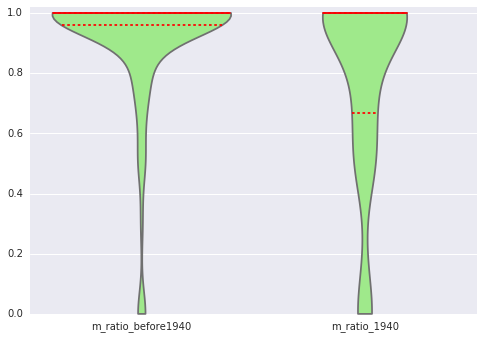

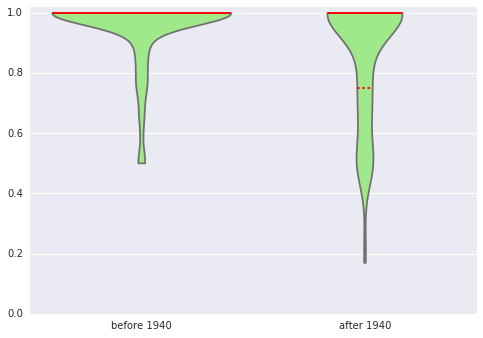

In [113]:
df_m_w["m_ratio_before1940"]=df_m_w.apply(lambda x: (float(x.all_men)-float(x.men_1940))/\
                                          float(x.all_men-x.men_1940+x.all_women-x.women_1940) \
                                    if float(x.all_men-x.men_1940+x.all_women-x.women_1940)>0 else None, axis = 1)
g=sns.violinplot(data=df_m_w[["m_ratio_before1940","m_ratio_1940"]],cut=0,trim=True,inner="quartile",
                 palette=[sns.xkcd_rgb["light green"]])
plt.ylim(0,1.02)
plt.show()

std_2=df_m_w["m_ratio_before1940"].std()*2
mean_m=df_m_w["m_ratio_before1940"].mean()
df2=df_m_w[ abs(df_m_w["m_ratio_before1940"] - mean_m)<std_2]["m_ratio_before1940"]
df_m_w2=pd.concat([df_m_w2,df2],axis=1)

g=sns.violinplot(data=df_m_w2[["m_ratio_before1940","m_ratio_1940"]],cut=0,trim=True,inner="quartile",
                 palette=[sns.xkcd_rgb["light green"]])
plt.ylim(0,1.02)
plt.xticks([0,1],["before 1940","after 1940"])
plt.show()

In [114]:
result_df = pd.concat([df_m_w, df], axis=1, join_axes=[df_m_w.index])

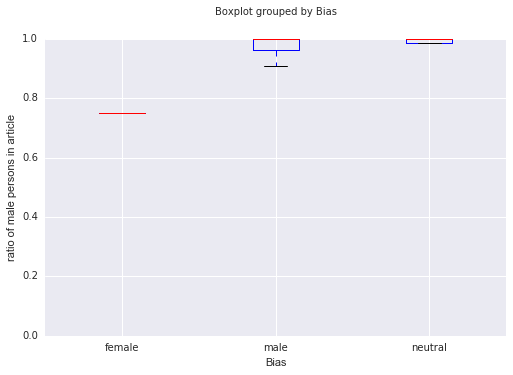

In [115]:
g=result_df.boxplot(by='Bias',column="m_ratio_before1940", return_type="axes")
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.show()
#plt.xticks(range(1,4),["female\nn=2","male\nn=234","neutral\nn=21"])

In [116]:
print result_df.groupby("Bias").size()
result_df[result_df.Bias=="female"][["m_ratio","all_men","all_women","men_1940","women_1940",
                                     "m_ratio_1940","m_ratio_1960","m_ratio_before1940"]]

Bias
female       2
male       231
neutral     21
dtype: int64


,m_ratio,all_men,all_women,men_1940,women_1940,m_ratio_1940,m_ratio_1960,m_ratio_before1940
Gleichstellungsbeauftragte,0.000000,0,1,0,1,0,NaN,NaN
Hebamme,0.785714,11,3,2,0,1,1,0.75


In [127]:
print len(result_df[(result_df.Bias=="female")&(~ result_df.m_ratio_1940.isnull())])
print len(result_df[(result_df.Bias=="neutral")&(~ result_df.m_ratio_1940.isnull())])
print len(result_df[(result_df.Bias=="male")&(~ result_df.m_ratio_1940.isnull())])
result_df[(result_df.Bias=="neutral")&(~ result_df.m_ratio_1940.isnull())][["m_ratio","all_men","all_women","men_1940","women_1940",
                                     "m_ratio_1940","m_ratio_1960","m_ratio_before1940"]]

2
13
127


,m_ratio,all_men,all_women,men_1940,women_1940,m_ratio_1940,m_ratio_1960,m_ratio_before1940
Apotheker,0.952381,20,1,1,0,1.000000,NaN,0.950000
Bote,1.000000,1,0,1,0,1.000000,NaN,NaN
Botin,0.500000,1,1,0,1,0.000000,0.00,1.000000
Bundeskanzlerin,0.000000,0,3,0,3,0.000000,NaN,NaN
Diakon,0.833333,5,1,1,1,0.500000,0.00,1.000000
Diakonin,0.818182,9,2,2,0,1.000000,NaN,0.777778
Fachkraft für Automatenservice,0.500000,1,1,1,1,0.500000,1.00,NaN
Filmgeschäftsführung,1.000000,1,0,1,0,1.000000,NaN,NaN
Hilfspolizei,0.888889,8,1,4,1,0.800000,0.00,1.000000
Hostess,0.500000,1,1,1,1,0.500000,NaN,NaN


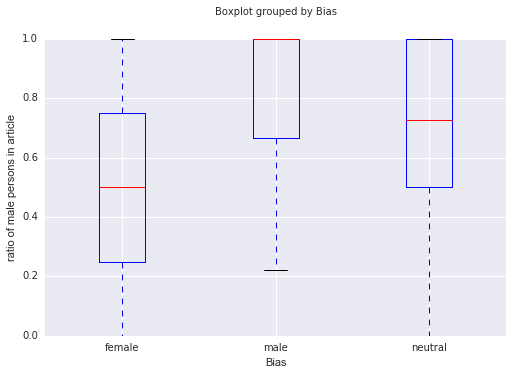

In [118]:
g=result_df.boxplot(by='Bias',column="m_ratio_1940", return_type="axes")
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.show()

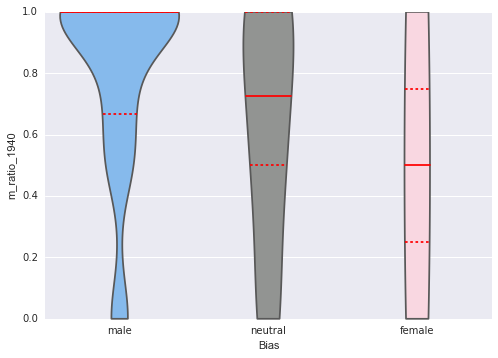

In [119]:
g=sns.violinplot(data=result_df,y="m_ratio_1940",x="Bias",cut=0,trim=True,inner="quartile",order=["male","neutral","female"],
                 palette=[sns.xkcd_rgb["sky blue"], sns.xkcd_rgb["grey"],sns.xkcd_rgb["light pink"]])

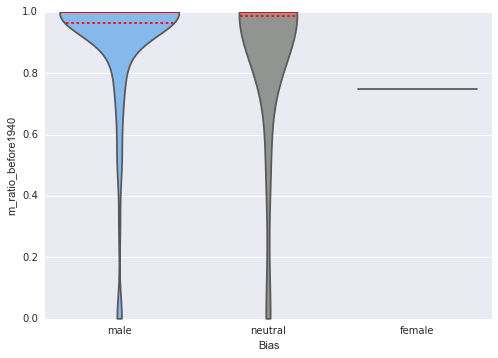

In [128]:
g=sns.violinplot(data=result_df,y="m_ratio_before1940",x="Bias",cut=0,trim=True,inner="quartile",order=["male","neutral","female"],
                 palette=[sns.xkcd_rgb["sky blue"], sns.xkcd_rgb["grey"],sns.xkcd_rgb["light pink"]])

(0, 1.02)

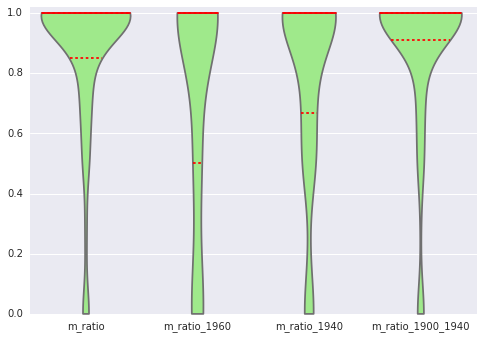

In [129]:
g=sns.violinplot(data=df_m_w[["m_ratio","m_ratio_1960","m_ratio_1940","m_ratio_1900_1940"]],cut=0,trim=True,inner="quartile",
                 palette=[sns.xkcd_rgb["light green"]])
plt.ylim(0,1.02)

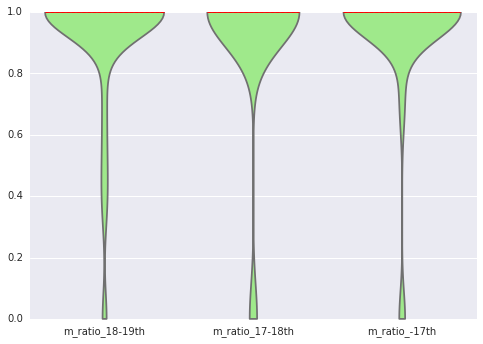

In [130]:
g=sns.violinplot(data=df_m_w[["m_ratio_18-19th","m_ratio_17-18th","m_ratio_-17th"]],cut=0,trim=True,inner="quartile",
                 palette=[sns.xkcd_rgb["light green"]])

# Correlation between numbers mentioned people and labor market statistics

C:\Anaconda\lib\site-packages\seaborn\linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
C:\Anaconda\lib\site-packages\seaborn\linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


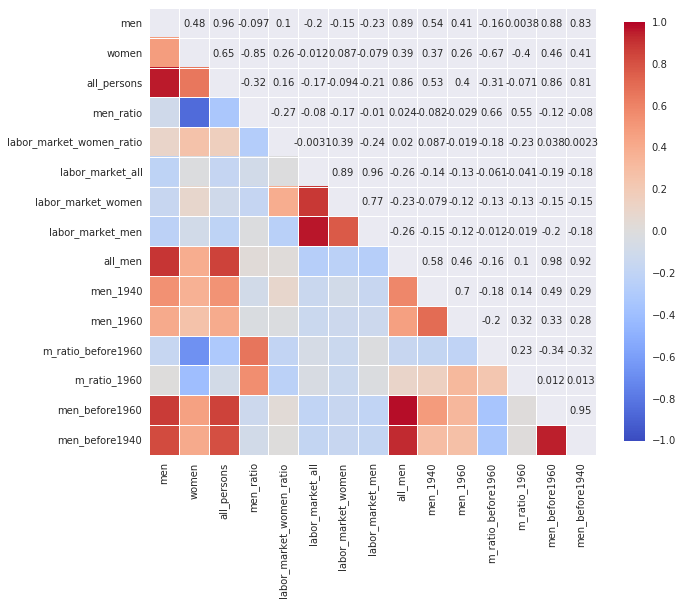

In [123]:

df_copy=pd.read_csv('de/all_persons_and_labor_market.csv', sep='\t',index_col=0,encoding='utf-8')

df_copy=pd.concat([df_copy,df_m_w[["all_men","men_1940","men_1960","m_ratio_before1960","m_ratio_1960"]]],axis=1)
df_copy["men_before1960"]=df_copy.apply(lambda x: float(x["all_men"])-float(x["men_1960"]) if float(x["all_men"])>0 else None, axis = 1)
df_copy["men_before1940"]=df_copy.apply(lambda x: float(x["all_men"])-float(x["men_1940"]) if float(x["all_men"])>0 else None, axis = 1)

#df_copy.dropna(inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.corrplot(df_copy,method="spearman",diag_names=False)

In [124]:
from scipy.stats import spearmanr
df_copy=df_copy[["men","women","all_persons","men_ratio","labor_market_women_ratio",
                 "labor_market_all","labor_market_women","labor_market_men","all_men",
                 "men_1940","men_1960","men_before1960","men_before1940","m_ratio_before1960","m_ratio_1960"]]
#construct two arrays, one of the correlation and the other of the p-vals
rho = df_copy.corr(method='spearman')
pval = np.zeros([df_copy.shape[1],df_copy.shape[1]])
pval2=np.zeros([df_copy.shape[1],df_copy.shape[1]])
spr=np.zeros([df_copy.shape[1],df_copy.shape[1]])
for i in range(df_copy.shape[1]): # rows are the number of rows in the matrix.
    for j in range(df_copy.shape[1]):
        JonI        = pd.ols(y=df_copy.icol(i), x=df_copy.icol(j), intercept=True)
        pval[i,j]  = JonI.f_stat['p-value']
        a=df_copy[~((df_copy.icol(i).isnull())|(df_copy.icol(j).isnull()))]
        pval2[i,j]= spearmanr(a.icol(i),a.icol(j))[1]
        spr[i,j]= spearmanr(a.icol(i),a.icol(j))[0]

rho

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]


,men,women,all_persons,men_ratio,labor_market_women_ratio,labor_market_all,labor_market_women,labor_market_men,all_men,men_1940,men_1960,men_before1960,men_before1940,m_ratio_before1960,m_ratio_1960
men,1.000000,0.478654,0.960924,-0.097164,0.104775,-0.204663,-0.149762,-0.226497,0.891249,0.536587,0.413249,0.877298,0.826714,-0.161293,0.003774
women,0.478654,1.000000,0.652638,-0.854905,0.262048,-0.012283,0.087044,-0.079090,0.393198,0.368770,0.258299,0.459909,0.410242,-0.668435,-0.396500
all_persons,0.960924,0.652638,1.000000,-0.322694,0.164052,-0.166609,-0.094258,-0.205084,0.855821,0.525790,0.404626,0.857064,0.805237,-0.308602,-0.071326
men_ratio,-0.097164,-0.854905,-0.322694,1.000000,-0.271342,-0.079568,-0.170079,-0.010439,0.024116,-0.081584,-0.029477,-0.119769,-0.079768,0.663679,0.551632
labor_market_women_ratio,0.104775,0.262048,0.164052,-0.271342,1.000000,-0.003129,0.391813,-0.238664,0.019924,0.087003,-0.018906,0.037543,0.002325,-0.181602,-0.231789
labor_market_all,-0.204663,-0.012283,-0.166609,-0.079568,-0.003129,1.000000,0.889263,0.961240,-0.262282,-0.135478,-0.126892,-0.190656,-0.176845,-0.060547,-0.040972
labor_market_women,-0.149762,0.087044,-0.094258,-0.170079,0.391813,0.889263,1.000000,0.767696,-0.228731,-0.079496,-0.118199,-0.150917,-0.152046,-0.130239,-0.131264
labor_market_men,-0.226497,-0.079090,-0.205084,-0.010439,-0.238664,0.961240,0.767696,1.000000,-0.261784,-0.151637,-0.122913,-0.195084,-0.175817,-0.012266,-0.019308
all_men,0.891249,0.393198,0.855821,0.024116,0.019924,-0.262282,-0.228731,-0.261784,1.000000,0.579572,0.461195,0.981266,0.922457,-0.155039,0.103083
men_1940,0.536587,0.368770,0.525790,-0.081584,0.087003,-0.135478,-0.079496,-0.151637,0.579572,1.000000,0.696461,0.488580,0.293328,-0.175881,0.144509


In [125]:
names=["men","women","all_persons","men_ratio","labor_market_women_ratio","labor_market_all",
    "labor_market_women","labor_market_men","all_men","men_1940","men_1960","men_before1960","men_before1940",
       "m_ratio_before1960","m_ratio_1960"]
pd.DataFrame(pval2,index=names,columns=names)

,men,women,all_persons,men_ratio,labor_market_women_ratio,labor_market_all,labor_market_women,labor_market_men,all_men,men_1940,men_1960,men_before1960,men_before1940,m_ratio_before1960,m_ratio_1960
men,0.000000e+00,6.343011e-25,2.936477e-230,4.901379e-02,3.527115e-02,3.399790e-05,2.545499e-03,4.258911e-06,1.626780e-88,2.427985e-20,6.751464e-12,1.794179e-78,7.002763e-62,1.096230e-02,9.747204e-01
women,6.343011e-25,0.000000e+00,3.069111e-51,1.238928e-118,9.068749e-08,8.055786e-01,8.055864e-02,1.124560e-01,8.069611e-11,1.333717e-09,3.083168e-05,4.543548e-14,3.061940e-11,1.789676e-33,5.151891e-04
all_persons,2.936477e-230,3.069111e-51,0.000000e+00,2.052580e-11,9.341434e-04,7.739650e-04,5.837129e-02,3.272947e-05,4.216856e-74,1.854747e-19,2.002574e-11,4.506047e-71,2.135382e-56,7.165122e-07,5.487360e-01
men_ratio,4.901379e-02,1.238928e-118,2.052580e-11,0.000000e+00,3.002182e-08,1.102918e-01,5.969521e-04,8.343177e-01,7.020882e-01,1.949811e-01,6.400907e-01,6.285362e-02,2.162930e-01,7.314560e-33,4.231225e-07
labor_market_women_ratio,3.527115e-02,9.068749e-08,9.341434e-04,3.002182e-08,0.000000e+00,9.500147e-01,2.831158e-16,1.219070e-06,7.539206e-01,1.702654e-01,7.661192e-01,5.643828e-01,9.715418e-01,4.429373e-03,5.351382e-02
labor_market_all,3.399790e-05,8.055786e-01,7.739650e-04,1.102918e-01,9.500147e-01,0.000000e+00,1.223571e-138,4.801370e-227,2.668823e-05,3.225456e-02,4.502717e-02,3.147496e-03,6.229245e-03,3.463064e-01,7.362930e-01
labor_market_women,2.545499e-03,8.055864e-02,5.837129e-02,5.969521e-04,2.831158e-16,1.223571e-138,0.000000e+00,1.046999e-79,2.654258e-04,2.103407e-01,6.203224e-02,1.984125e-02,1.892680e-02,4.209096e-02,2.787403e-01
labor_market_men,4.258911e-06,1.124560e-01,3.272947e-05,8.343177e-01,1.219070e-06,4.801370e-227,1.046999e-79,0.000000e+00,2.768041e-05,1.641876e-02,5.225105e-02,2.503944e-03,6.541945e-03,8.488240e-01,8.739476e-01
all_men,1.626780e-88,8.069611e-11,4.216856e-74,7.020882e-01,7.539206e-01,2.668823e-05,2.654258e-04,2.768041e-05,0.000000e+00,3.431943e-24,8.799232e-15,1.173051e-173,3.579205e-101,1.452453e-02,3.854724e-01
men_1940,2.427985e-20,1.333717e-09,1.854747e-19,1.949811e-01,1.702654e-01,3.225456e-02,2.103407e-01,1.641876e-02,3.431943e-24,0.000000e+00,3.448833e-38,6.351203e-16,3.450553e-06,5.478476e-03,2.225458e-01
